In [34]:
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt

In [35]:
def leer_gadget2(file_path):
    with open(file_path, "rb") as f:
        # Leer primer bloque (tamaño del header)
        block_size_start = struct.unpack("I", f.read(4))[0]

        # Leer header (256 bytes)
        header_bytes = f.read(256)

        # Solo desempacamos lo necesario (npart: 6 enteros de 4 bytes)
        npart = struct.unpack("6I", header_bytes[:24])
        total_particles = sum(npart)

        # Saltar el resto del header
        block_size_end = struct.unpack("I", f.read(4))[0]
        assert block_size_start == block_size_end, "Block size mismatch en encabezado"

        # Leer posiciones
        block_size_start = struct.unpack("I", f.read(4))[0]
        positions = np.fromfile(f, dtype=np.float32, count=total_particles * 3).reshape((total_particles, 3))
        block_size_end = struct.unpack("I", f.read(4))[0]
        assert block_size_start == block_size_end, "Block size mismatch en posiciones"

        # Leer velocidades
        block_size_start = struct.unpack("I", f.read(4))[0]
        velocities = np.fromfile(f, dtype=np.float32, count=total_particles * 3).reshape((total_particles, 3))
        block_size_end = struct.unpack("I", f.read(4))[0]
        assert block_size_start == block_size_end, "Block size mismatch en velocidades"

        # Leer IDs
        block_size_start = struct.unpack("I", f.read(4))[0]
        ids = np.fromfile(f, dtype=np.uint32, count=total_particles)
        block_size_end = struct.unpack("I", f.read(4))[0]
        assert block_size_start == block_size_end, "Block size mismatch en IDs"

        # Intentar leer masas (si están presentes)
        try:
            block_size_start = struct.unpack("I", f.read(4))[0]
            masses = np.fromfile(f, dtype=np.float32, count=total_particles)
            block_size_end = struct.unpack("I", f.read(4))[0]
            assert block_size_start == block_size_end, "Block size mismatch en masas"
        except:
            masses = None

    # Crear DataFrame
    df = pd.DataFrame({
        "id": ids,
        "x": positions[:, 0],
        "y": positions[:, 1],
        "z": positions[:, 2],
        "v_x": velocities[:, 0],
        "v_y": velocities[:, 1],
        "v_z": velocities[:, 2],
    })

    if masses is not None:
        df["masa"] = masses

    return df

# Uso:
archivo = r"Archivos\AM2229-735_host_RL_050"
galaxia_df = leer_gadget2(archivo)
galaxia_df


,id,x,y,z,v_x,v_y,v_z,masa
0,429542,-6139.246094,-65.043045,-4120.191406,-211.133438,-2.388370,-141.643646,0.000030
1,2031584,-5968.082520,-808.355225,-4296.529785,-205.248184,-27.948269,-147.707611,0.000030
2,855092,-6168.680176,-1607.304321,-3851.701904,-212.151428,-55.422649,-132.414932,0.000030
3,1383630,-5093.544922,-2260.614502,-4018.954346,-175.120163,-77.861580,-138.118774,0.000030
4,865115,-4793.813965,-2562.677246,-3903.351074,-164.795074,-88.233559,-134.127151,0.000030
...,...,...,...,...,...,...,...,...
4334756,4176709,80.001984,31.998182,279.918488,20.145805,43.748489,8.327011,0.000004
4334757,4137086,53.549637,34.668991,276.359558,80.362534,-12.354066,20.103807,0.000004
4334758,4174688,13.888486,60.761311,265.012543,18.216602,17.566277,-44.761848,0.000004
4334759,4285619,57.072998,118.474464,271.629486,-40.505226,-79.648994,8.942924,0.000004


In [36]:
def centrar_galaxia(base_de_datos):
    
    masa_total_galaxia = base_de_datos.masa.sum()

    x_cm = base_de_datos.masa @ base_de_datos.x / masa_total_galaxia
    y_cm = base_de_datos.masa @ base_de_datos.y / masa_total_galaxia
    z_cm = base_de_datos.masa @ base_de_datos.z / masa_total_galaxia

    base_de_datos['x0'] = base_de_datos.x - x_cm
    base_de_datos['y0'] = base_de_datos.y - y_cm
    base_de_datos['z0'] = base_de_datos.z - z_cm

centrar_galaxia(galaxia_df)

galaxia_df

,id,x,y,z,v_x,v_y,v_z,masa,x0,y0,z0
0,429542,-6139.246094,-65.043045,-4120.191406,-211.133438,-2.388370,-141.643646,0.000030,-6142.972656,-63.242546,-4119.605957
1,2031584,-5968.082520,-808.355225,-4296.529785,-205.248184,-27.948269,-147.707611,0.000030,-5971.809082,-806.554749,-4295.944336
2,855092,-6168.680176,-1607.304321,-3851.701904,-212.151428,-55.422649,-132.414932,0.000030,-6172.406738,-1605.503784,-3851.116455
3,1383630,-5093.544922,-2260.614502,-4018.954346,-175.120163,-77.861580,-138.118774,0.000030,-5097.271484,-2258.813965,-4018.368896
4,865115,-4793.813965,-2562.677246,-3903.351074,-164.795074,-88.233559,-134.127151,0.000030,-4797.540527,-2560.876709,-3902.765625
...,...,...,...,...,...,...,...,...,...,...,...
4334756,4176709,80.001984,31.998182,279.918488,20.145805,43.748489,8.327011,0.000004,76.275436,33.798679,280.504028
4334757,4137086,53.549637,34.668991,276.359558,80.362534,-12.354066,20.103807,0.000004,49.823093,36.469490,276.945099
4334758,4174688,13.888486,60.761311,265.012543,18.216602,17.566277,-44.761848,0.000004,10.161942,62.561810,265.598083
4334759,4285619,57.072998,118.474464,271.629486,-40.505226,-79.648994,8.942924,0.000004,53.346455,120.274963,272.215027


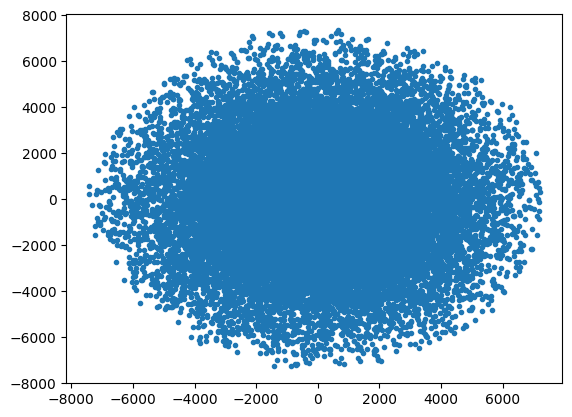

In [39]:
plt.scatter(x = galaxia_df.x0, y = galaxia_df.y0, marker= '.')
plt.show()